In [1]:
import glob as glob
import numpy as np
import cv2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from scipy.interpolate import make_interp_spline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

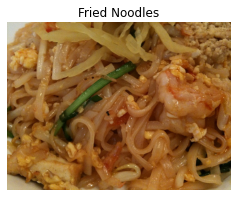

In [3]:
img = load_img('images/4012787089_d1cca54838.jpg')
plt.figure(figsize = (4,4))
plt.imshow(img)
plt.axis('off')
plt.title('Fried Noodles')
plt.show()

In [4]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

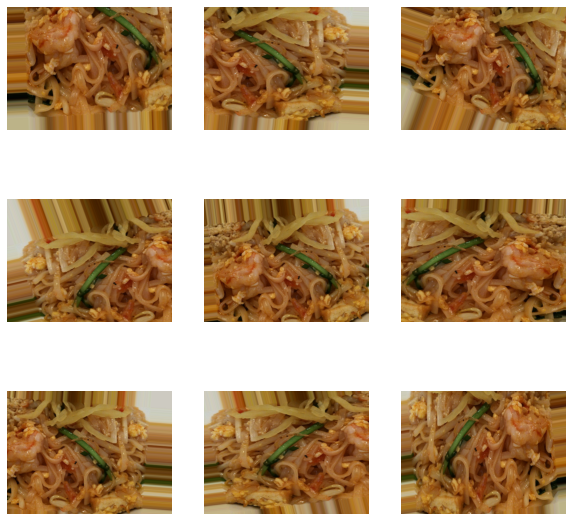

In [5]:
i = 0
fig = plt.figure(figsize = (10,10))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

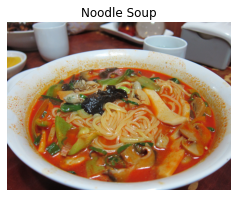

In [6]:
img = load_img('images/5153183161_eb845fb8d9_b.jpg')
plt.figure(figsize = (4,4))
plt.imshow(img)
plt.axis('off')
plt.title('Noodle Soup')
plt.show()

In [7]:
# configuración por defecto
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [8]:
# pre-procesamiento de datos para entrenamiento
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [9]:
# pre-procesamiento de datos para su validación
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [10]:
# generar y almacenar datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 315 images belonging to 2 classes.


In [11]:
# generar y almacenar datos de validación
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 36 images belonging to 2 classes.


In [12]:
# Configure el aprendizaje de transferencia en el modelo ImageNet VGG19 previamente entrenado: 
# elimine la capa completamente conectada y reemplace con softmax para clasificar 2 clases
vgg19_model = VGG19(weights = 'imagenet', include_top = False)
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(vgg19_model.input, predictions)

In [13]:
# congelar todas las capas del modelo previamente entrenado
for layer in vgg19_model.layers:
    layer.trainable = False

In [14]:
# compile el nuevo modelo usando un optimizador RMSProp
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
# ajustar el modelo, registrar los resultados y el tiempo de entrenamiento
transfer_learning_history = model.fit(
    train_generator,
    epochs = nb_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = validate_generator,
    validation_steps = len(validate_generator), verbose = 1)

Epoch 1/20
10/10 [==============================] - 70s 7s/step - loss: 0.8868 - accuracy: 0.6286 - val_loss: 0.5026 - val_accuracy: 0.8056
Epoch 2/20
10/10 [==============================] - 69s 7s/step - loss: 0.5008 - accuracy: 0.7556 - val_loss: 0.5225 - val_accuracy: 0.7778
Epoch 3/20
10/10 [==============================] - 74s 7s/step - loss: 0.4235 - accuracy: 0.8159 - val_loss: 0.4599 - val_accuracy: 0.7778
Epoch 4/20
10/10 [==============================] - 69s 7s/step - loss: 0.5234 - accuracy: 0.7397 - val_loss: 0.4688 - val_accuracy: 0.8056
Epoch 5/20
10/10 [==============================] - 69s 7s/step - loss: 0.4153 - accuracy: 0.8032 - val_loss: 0.5389 - val_accuracy: 0.8056
Epoch 6/20
10/10 [==============================] - 71s 7s/step - loss: 0.3945 - accuracy: 0.8190 - val_loss: 0.5405 - val_accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 74s 7s/step - loss: 0.3817 - accuracy: 0.8286 - val_loss: 0.5347 - val_accuracy: 0.7222
Epoch 8/20
10/10 [==

In [17]:
# Evaluar el rendimiento del nuevo modelo e informar de los resultados
score = model.evaluate_generator(validate_generator, len(validate_generator))
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Score: 0.4246663451194763
Test Accuracy: 0.75


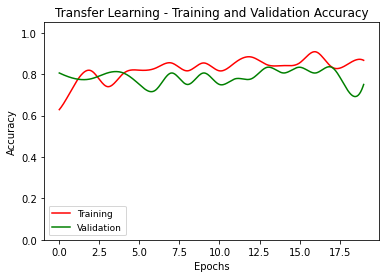

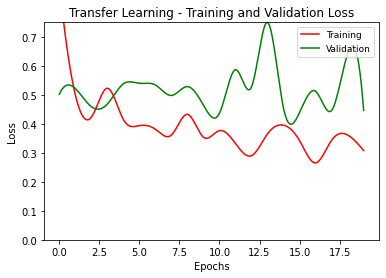

In [19]:
xfer_acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x,y)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = make_interp_spline(x1,y1)(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x,y)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = make_interp_spline(x1,y1)(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [20]:
predict_files = glob.glob("./data/test/*.jpg")

In [21]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [22]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [23]:
final = pd.DataFrame()
final["id"] = image_id
final["Noodles"] = predictor
final.head(29)

,id,Noodles
0,noodles_fried_11907714416_43d097a388_b.jpg,0
1,noodles_fried_12773173773_8b979e09a3_b.jpg,0
2,noodles_fried_12780501384_e09c5c8e9e_b.jpg,0
3,noodles_fried_13465247115_3a5d9e8bda.jpg,0
4,noodles_fried_21801699575_797999fc3b_b.jpg,0
5,noodles_fried_2683621518_dd75c9ba12_b.jpg,1
6,noodles_fried_2725335486_4988c93cc4_b.jpg,0
7,noodles_fried_325511866_82e17cec74_b.jpg,1
8,noodles_fried_3959302738_054794e5e9_b.jpg,0
9,noodles_fried_4629495314_54b073df68_b.jpg,0


In [24]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [25]:
final["Noodles"] = final["Noodles"].apply(lambda x: classes[x])
final.head(29)

,id,Noodles
0,noodles_fried_11907714416_43d097a388_b.jpg,noodles_fried
1,noodles_fried_12773173773_8b979e09a3_b.jpg,noodles_fried
2,noodles_fried_12780501384_e09c5c8e9e_b.jpg,noodles_fried
3,noodles_fried_13465247115_3a5d9e8bda.jpg,noodles_fried
4,noodles_fried_21801699575_797999fc3b_b.jpg,noodles_fried
5,noodles_fried_2683621518_dd75c9ba12_b.jpg,noodles_soup
6,noodles_fried_2725335486_4988c93cc4_b.jpg,noodles_fried
7,noodles_fried_325511866_82e17cec74_b.jpg,noodles_soup
8,noodles_fried_3959302738_054794e5e9_b.jpg,noodles_fried
9,noodles_fried_4629495314_54b073df68_b.jpg,noodles_fried


**Grafique** esto para poder ver todo el set de la predicción de las 10 clases.

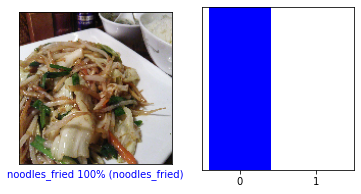

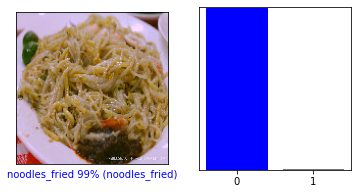

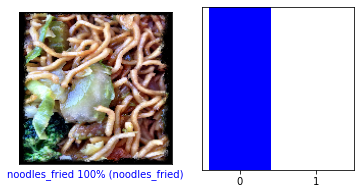

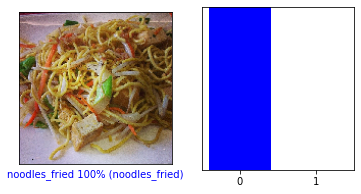

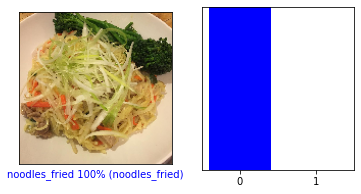

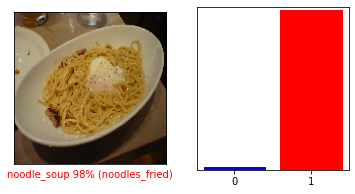

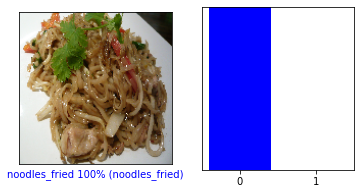

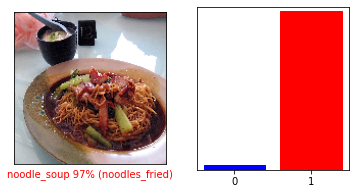

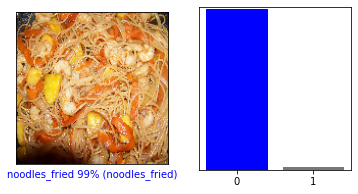

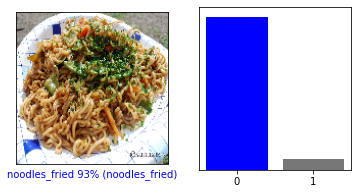

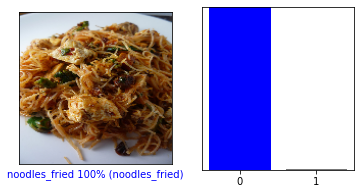

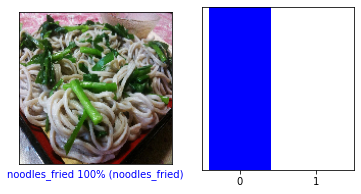

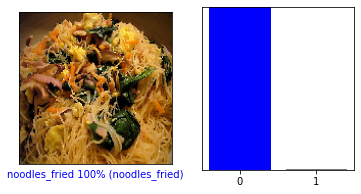

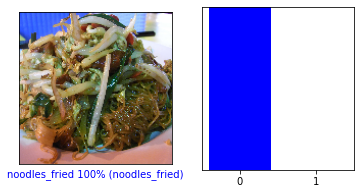

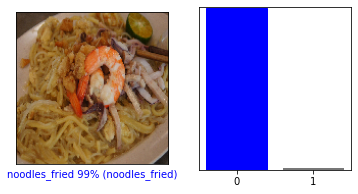

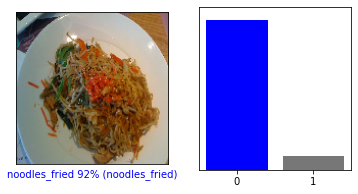

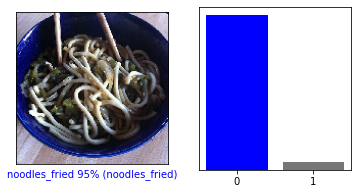

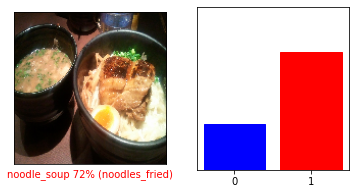

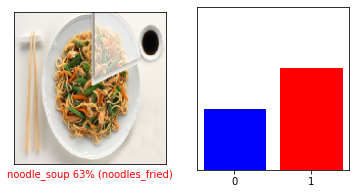

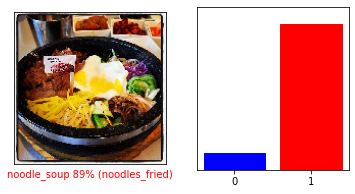

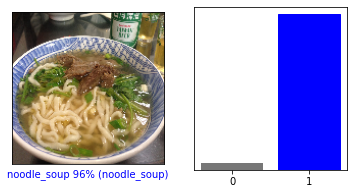

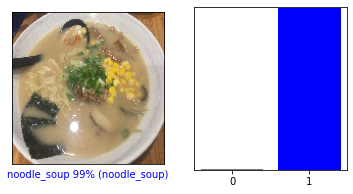

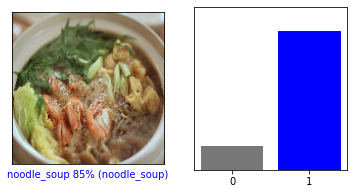

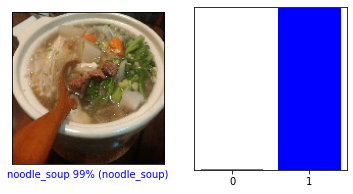

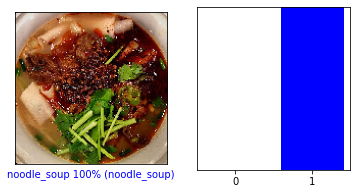

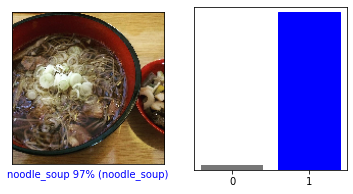

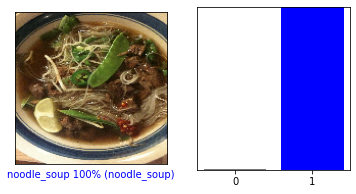

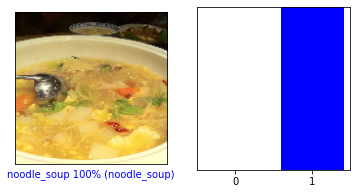

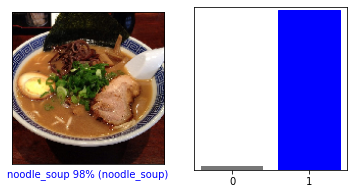

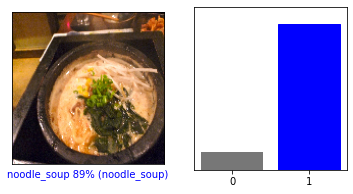

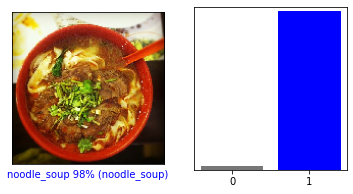

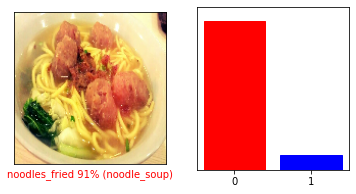

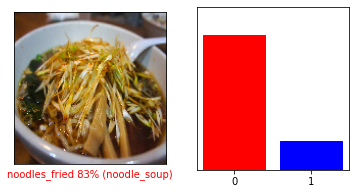

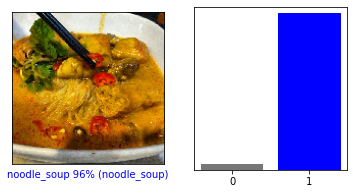

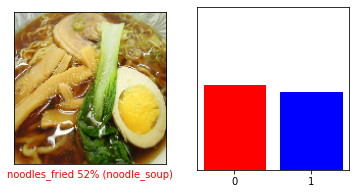

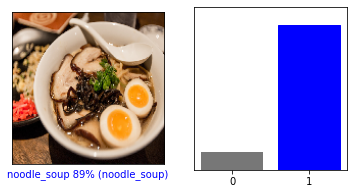

In [29]:
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
longitud, altura = 150, 150
clases = ['noodles_fried','noodle_soup']
path =  "./data/test"
Ima = os.listdir(path)
for w in Ima:
    RutaImg=path+'/'+w
    img = load_img(RutaImg, target_size=(longitud, altura))
    x = img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    array = model.predict(x)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(array[0])
    if (w.find(clases[0]) != -1):
        i = 0
    elif (w.find(clases[1]) != -1):
        i = 1 

    if (predicted_label == i):
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(clases[predicted_label],100*np.max(array[0]),clases[i]),color=color)

    plt.subplot(1,2,2)
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), array[0],color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(array[0])
    thisplot[predicted_label].set_color('red')
    thisplot[i].set_color('blue')
    plt.show()